In [1]:
import warnings, os
warnings.filterwarnings("ignore")


import pandas as pd
import numpy as np

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score
from sklearn.metrics import auc as calculate_auc

import matplotlib.pyplot as plt
import seaborn as sns

from aggmap import AggMap, AggMapNet

np.random.seed(666) #just for reaptable results

def prc_auc_score(y_true, y_score):
    precision, recall, threshold  = precision_recall_curve(y_true, y_score) #PRC_AUC
    auc = calculate_auc(recall, precision)
    return auc

sns.set(style='white',  font='Times New Roman', font_scale=2)  

In [129]:
dfx = pd.read_excel('../CRC.xlsx', sheet_name='data')
dfx = dfx[dfx.columns[1:]]
dfx = np.log(dfx + 1e-8)

feature_groups_df = pd.read_excel('../CRC.xlsx', sheet_name='feature_info')
feature_group_list = feature_groups_df.Group.tolist()

dfy_all = pd.read_excel('../CRC.xlsx', sheet_name='sample_info')
dfy = pd.get_dummies(dfy_all['Group'])


X = dfx.values.astype(float)
Y = dfy.values.astype(float)

from sklearn.linear_model import Lasso

from sklearn.preprocessing import StandardScaler, MinMaxScaler
S = StandardScaler()
X = S.fit_transform(X)

In [130]:
country_idx = dfy_all.groupby(['Country']).apply(lambda x:x.index.tolist())
country_idx

Country
AUS    [114, 115, 116, 117, 118, 119, 120, 121, 122, ...
CHI    [223, 224, 225, 226, 227, 228, 229, 230, 231, ...
FRA    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
GER    [455, 456, 457, 458, 459, 460, 461, 462, 463, ...
USA    [351, 352, 353, 354, 355, 356, 357, 358, 359, ...
dtype: object

In [131]:
country_names = country_idx.index.tolist()

In [166]:
#study to study transfer
fimps = []
run_all = []
clfs = []
for train_country in country_names:

    train_idx = country_idx.loc[train_country]

    trainX = X[train_idx]
    trainY = Y[train_idx]

    clf = Lasso(alpha=0.023, random_state=42, max_iter=1000)
    clf.fit(trainX, trainY)  

    clfs.append(clf)

    imp = pd.DataFrame(np.abs(clf.coef_), columns=dfx.columns.tolist()).T[1]
    #imp = pd.Series(clf.coef_[1], index=dfx.columns.tolist())
    fimp = imp.to_frame(name = train_country)
    fimps.append(fimp)
        
    for test_country in country_names:
        
        test_idx = country_idx.loc[test_country]
        testY = Y[test_idx]
        testX = X[test_idx]

       
        #print("\n input train and test X shape is %s, %s " % (trainX.shape,  testX.shape))

        y_true = testY[:,0]
        y_pred = pd.DataFrame(clf.predict(testX)).idxmin(axis=1).values
        y_score = clf.predict(testX)[:,0]

        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        acc = (tp + tn) / sum([tn, fp, fn, tp])

        sensitivity = tp / sum([tp, fn])
        specificity = tn / sum([tn, fp])

        prc_auc = prc_auc_score(y_true, y_score)
        roc_auc = roc_auc_score(y_true, y_score)

        precision = tp / sum([tp, fp])
        recall =  tp / sum([tp, fn]) #equals to sensitivity


        res = {'train_country': train_country,
               'test_country':test_country,

               'accuracy':acc, 

               'prc_auc':prc_auc, 
               'roc_auc':roc_auc,

               'sensitivity': sensitivity, 
               'specificity': specificity,

               'precision':precision,
               'recall':recall,
              }

        
        run_all.append(res)

In [167]:
df = pd.DataFrame(run_all)

dfres = pd.crosstab(index = df.train_country, columns= df.test_country, values= df.roc_auc, aggfunc = np.mean)

In [168]:
dfres = dfres.rename(columns = {'AUS':"AUS", 'CHI':'CHN', 'FRA':'FRA', 'GER':'DEU', 'USA':'USA'},
                    index =  {'AUS':"AUS", 'CHI':'CHN', 'FRA':'FRA', 'GER':'DEU', 'USA':'USA'}
                    )


In [169]:
# 	AUS	CHN	DEU	FRA	USA
# Training set					
# AUS	1.000	0.746	0.888	0.754	0.781
# CHN	0.821	1.000	0.896	0.794	0.763
# DEU	0.856	0.857	1.000	0.811	0.780
# FRA	0.880	0.864	0.924	1.000	0.768
# USA	0.856	0.764	0.811	0.692	1.000

dfres.to_csv('lasso_STST.csv')
dfres

test_country,AUS,CHN,FRA,DEU,USA
train_country,,,,,
AUS,1.000000,0.714965,0.607795,0.616111,0.582101
CHN,0.855763,0.998749,0.785957,0.837778,0.680104
FRA,0.712560,0.804805,1.000000,0.831944,0.634985
DEU,0.741546,0.894895,0.763996,1.000000,0.649038
USA,0.817115,0.638138,0.766471,0.753333,1.000000


In [170]:
coef = pd.concat(fimps, axis=1)
coef = coef.rename(columns = {'AUS':"AUS", 'CHI':'CHN', 'FRA':'FRA', 'GER':'DEU', 'USA':'USA'})

coef.to_csv('lasso_coef.csv')

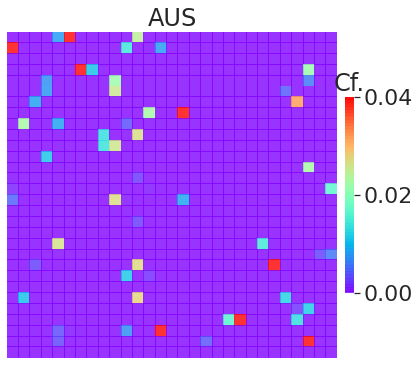

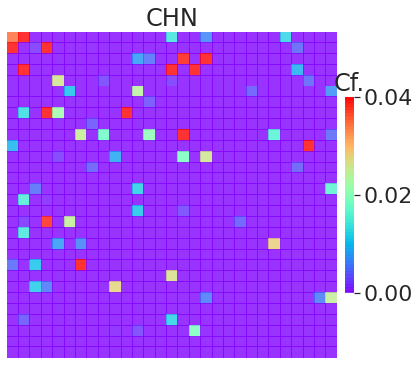

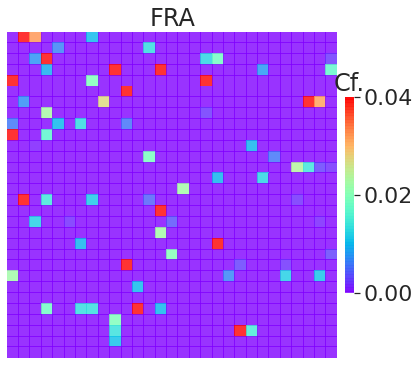

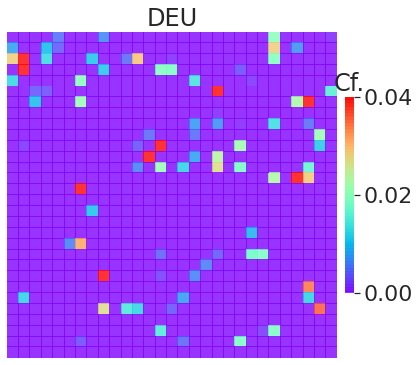

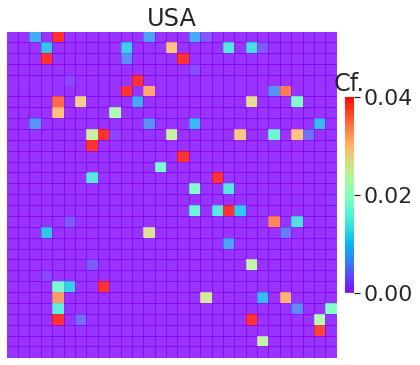

In [183]:
from aggmap import loadmap
from matplotlib.ticker import FormatStrFormatter
from matplotlib.colors import LogNorm, Normalize

df_imp = pd.read_excel('../results/feature_importance.xlsx',index_col=0)
df_imp = df_imp.sort_values(['grid_y', 'grid_x'])
idxes = []
for i, j in enumerate(df_imp.index):
    if j == 0:
        idx = 'NaN-%s' % i
    else:
        idx = j
    idxes.append(idx)
df_imp.index = idxes

mp = loadmap('../model/aggmap.mp')

for country in  coef.columns:

    fig, ax  = plt.subplots(1, 1, figsize=(6.5, 6))

    imp = pd.DataFrame(index=df_imp.index).join(coef).loc[df_imp.index][country].values
    imp = np.nan_to_num(imp, nan = 0.0)

    #imp = np.log10(imp)
    
    vmax = pd.Series(imp).sort_values(ascending=False).head(20).mean()
    
    sns.heatmap(imp.reshape(*mp.fmap_shape),  
                cmap = 'rainbow', alpha = 0.8, ax =ax, yticklabels=0, xticklabels=0, vmin=0,
                  vmax=0.04,  #norm=Normalize(imp.min(),imp.max()),
                cbar_kws = {'fraction':0.07, 'shrink':0.6, 
                            'aspect': 20, 'pad':0.02, #"ticks":[1, 1.01],
                            #'orientation':'horizontal'
                           }
               )

    bottom, top = ax.get_ylim()
    #ax.set_ylim(bottom + 0.5, top - 0.5)

    ax.set_title(country)
    cbar = ax.collections[0].colorbar
    cbar.ax.set_title('Cf.') # rotation=90,
    
    cbar.ax.locator_params(nbins=3)
    cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
    plt.subplots_adjust(wspace = 0.18)

    #plt.savefig('./fig/coef_%s.png' % country, dpi = 400, bbox_inches="tight")
    plt.savefig('./fig/coef_%s.pdf' % country, dpi = 400, bbox_inches="tight")

In [173]:
coef [coef.AUS > 0 ].shape

(64, 5)

In [185]:
coef.to_csv('./fig/02_coef.csv')

In [174]:
pd.DataFrame(index=df_imp.index).join(coef).loc[df_imp.index][country].sort_values()

unknown Peptostreptococcaceae [meta_mOTU_v2_5742]    0.0
Dorea longicatena [ref_mOTU_v2_2893]                 0.0
unknown Ruminococcaceae [meta_mOTU_v2_6905]          0.0
unknown Ruminococcaceae [meta_mOTU_v2_6557]          0.0
Ruminococcus lactaris [ref_mOTU_v2_0281]             0.0
                                                    ... 
NaN-865                                              NaN
NaN-866                                              NaN
NaN-867                                              NaN
NaN-868                                              NaN
NaN-869                                              NaN
Name: USA, Length: 870, dtype: float64

In [175]:
import eli5
eli5.show_weights(clfs[3], top=-1, feature_names = dfx.columns.tolist())

y0 top features,y1 top features
Weight?,Feature
+0.546,<BIAS>
+0.063,unknown Clostridiales [meta_mOTU_v2_7156]
+0.062,Parvimonas micra [ref_mOTU_v2_1145]
+0.048,unknown Ruminococcaceae [meta_mOTU_v2_7652]
+0.048,Solobacterium moorei [ref_mOTU_v2_0531]
+0.043,unknown Clostridiales [meta_mOTU_v2_7707]
+0.035,unknown Bacteroidales [meta_mOTU_v2_5647]
+0.029,Clostridium clostridioforme [ref_mOTU_v2_0979]
+0.029,unknown Firmicutes [meta_mOTU_v2_6906]
